In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import os
import json


#plot Options
import matplotlib as mpl
font = {#'family' : 'normal','weight' : 'bold',
        'size'   : 16
        #,'serif':['Helvetica']
        }
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 400

###
####constants
degree = np.pi/180 # convert form rad to degree


Attempt to model that the Capillary gets obscured by its housing 
in parts and not all at once

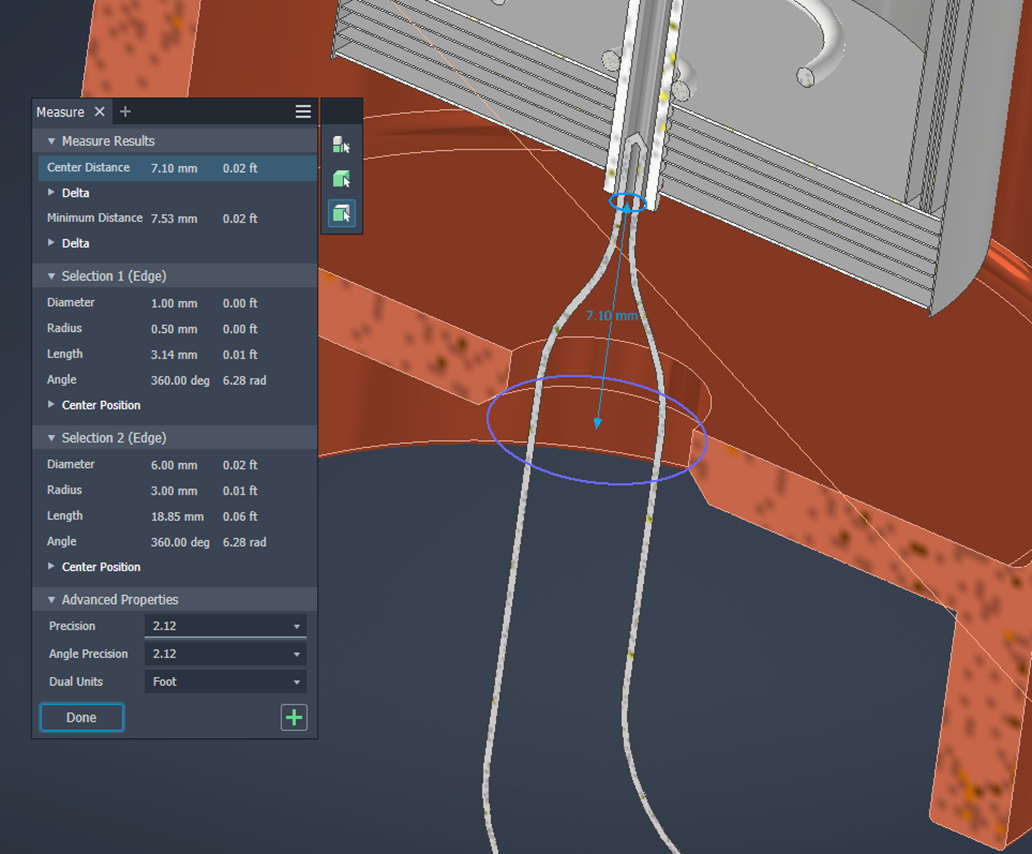

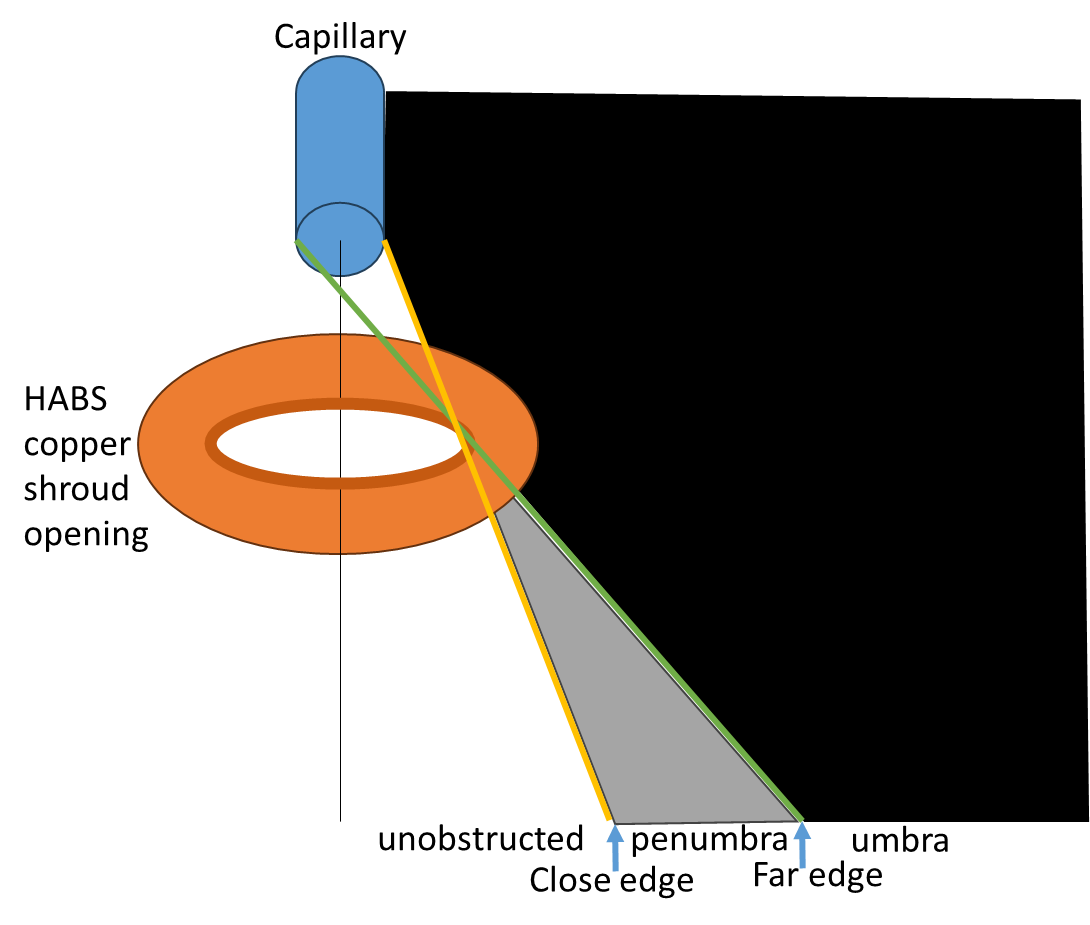

In [14]:
#2024-04-12 new version to be a real integral  over the capillary surface, and 
# to include an approximation for capillary intensity variation as seen in
# Sebastian Kochhs approximation
def visible_fraction(theta):
    # calculate fraction of the capillary that is visible under a
    # given angle
    # Presumes capillary to be centered on opening  in HABS housing
    radius_cap = 0.5 # mm
    distance_cap_housing = 7.1 # mm
    radius_housing = 3.0 # mm

    # calculate edges of penumbra
    # inner (close) edge
    theta_inner = np.arctan((radius_housing - radius_cap)
                            /distance_cap_housing)
    theta_outer = np.arctan((radius_housing + radius_cap)
                            /distance_cap_housing)

    # print("inner edge:", theta_inner, theta_inner / degree)
    # print("outer edge:", theta_outer, theta_outer / degree)#
    # # speed up by eliminating  this calculation
    # theta_inner = 0.3385556949116842 # 19.3978 deg 
    # theta_outer = 0.45799795159722173 # 26.2413 deg
    if np.abs(theta) <= theta_inner:
        fraction = 1
    elif np.abs(theta) >= theta_outer:
        fraction = 0
    else:
        # Take shortcut initially
        # HACK Linearly interpolate between inner and outer angles
        int_var = (2 *  ((theta_outer - np.abs(theta)) 
                    / (theta_outer - theta_inner))) - 1
        # Integrated circle equation
        vis_frac = lambda x: (np.sqrt(1-x**2) * x 
                                + np.arcsin(x)
                                + np.pi/2)/np.pi
        fraction = vis_frac(int_var)
    return fraction
    

In [15]:
visible_fraction(26*degree)

0.011123691454085673

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arcsin
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


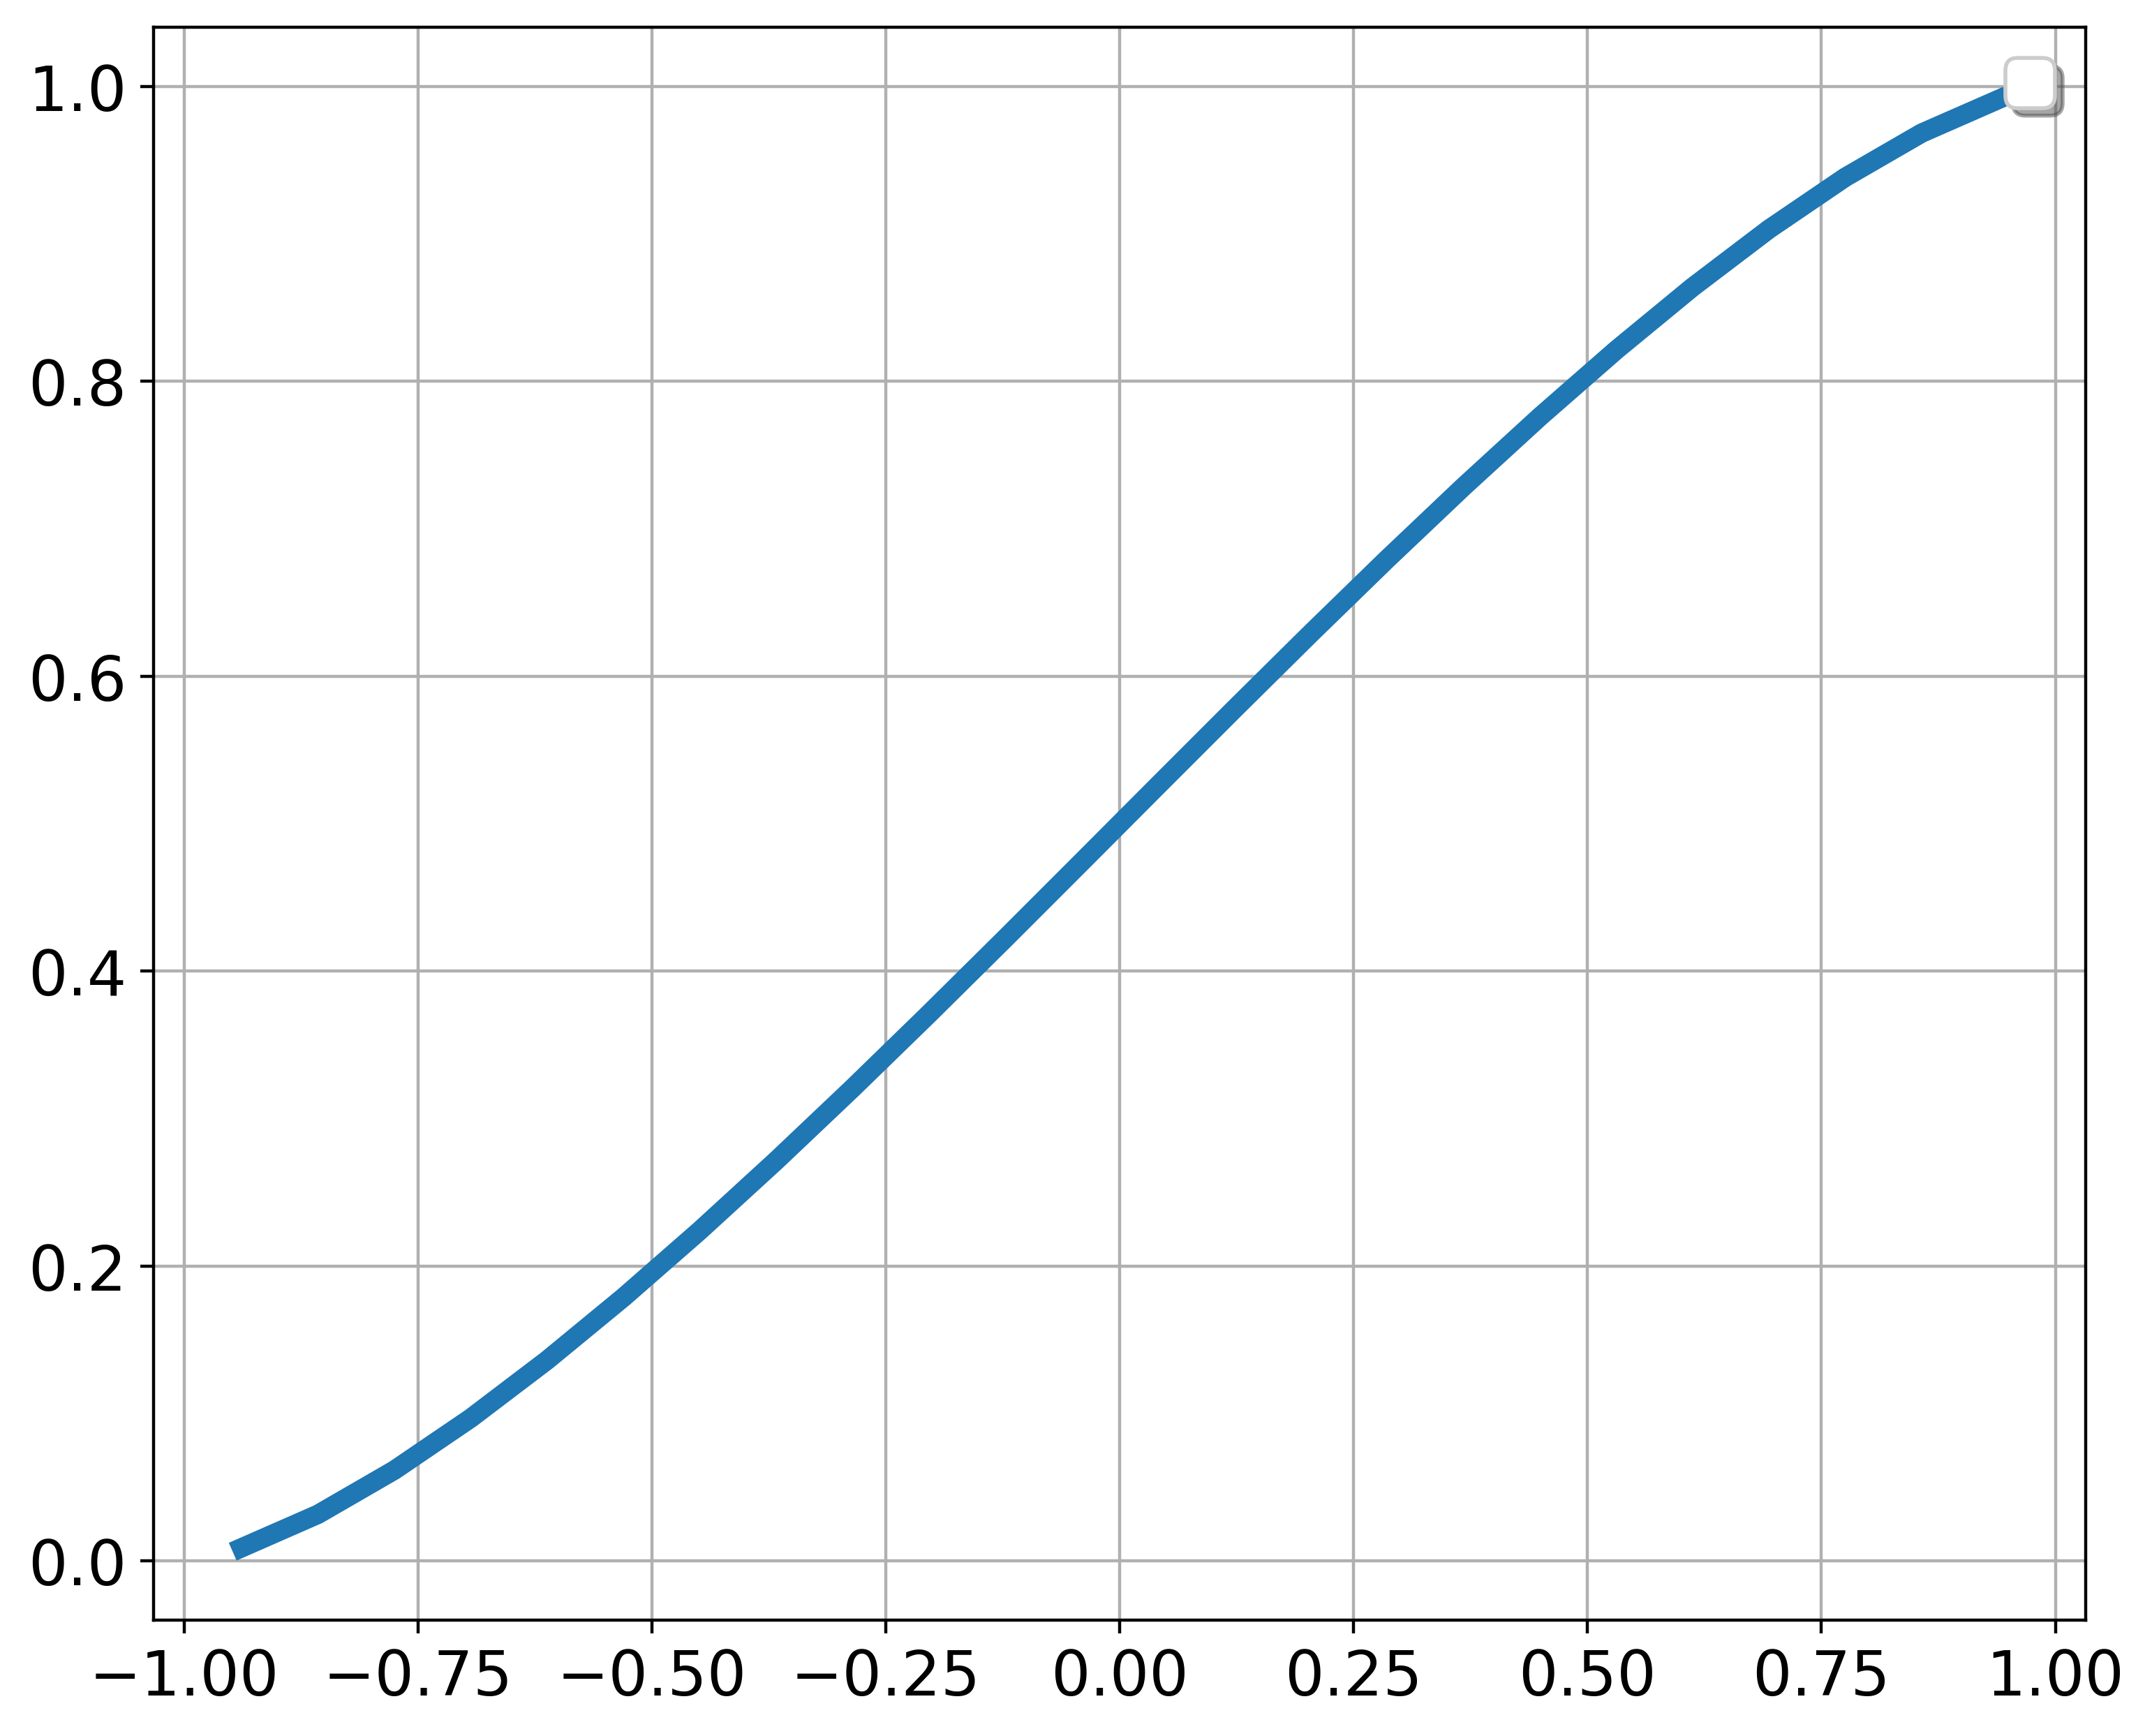

In [16]:
circ_int = lambda x: (np.sqrt(1-x**2) * x 
                        + np.arcsin(x)
                        + np.pi/2)/np.pi
xs = np.linspace(-2,2)
ys = np.real(circ_int(xs))
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()
ax1.plot(xs,ys,
        # color = "k" ,label = r"calib weights",
         lw= 5)


# ax1.set_xlabel(r"x [mm]")
# ax1.set_ylabel(r"A.U.")

plt.legend(shadow=True)
plt.tight_layout()
plt.grid(True)

No handles with labels found to put in legend.


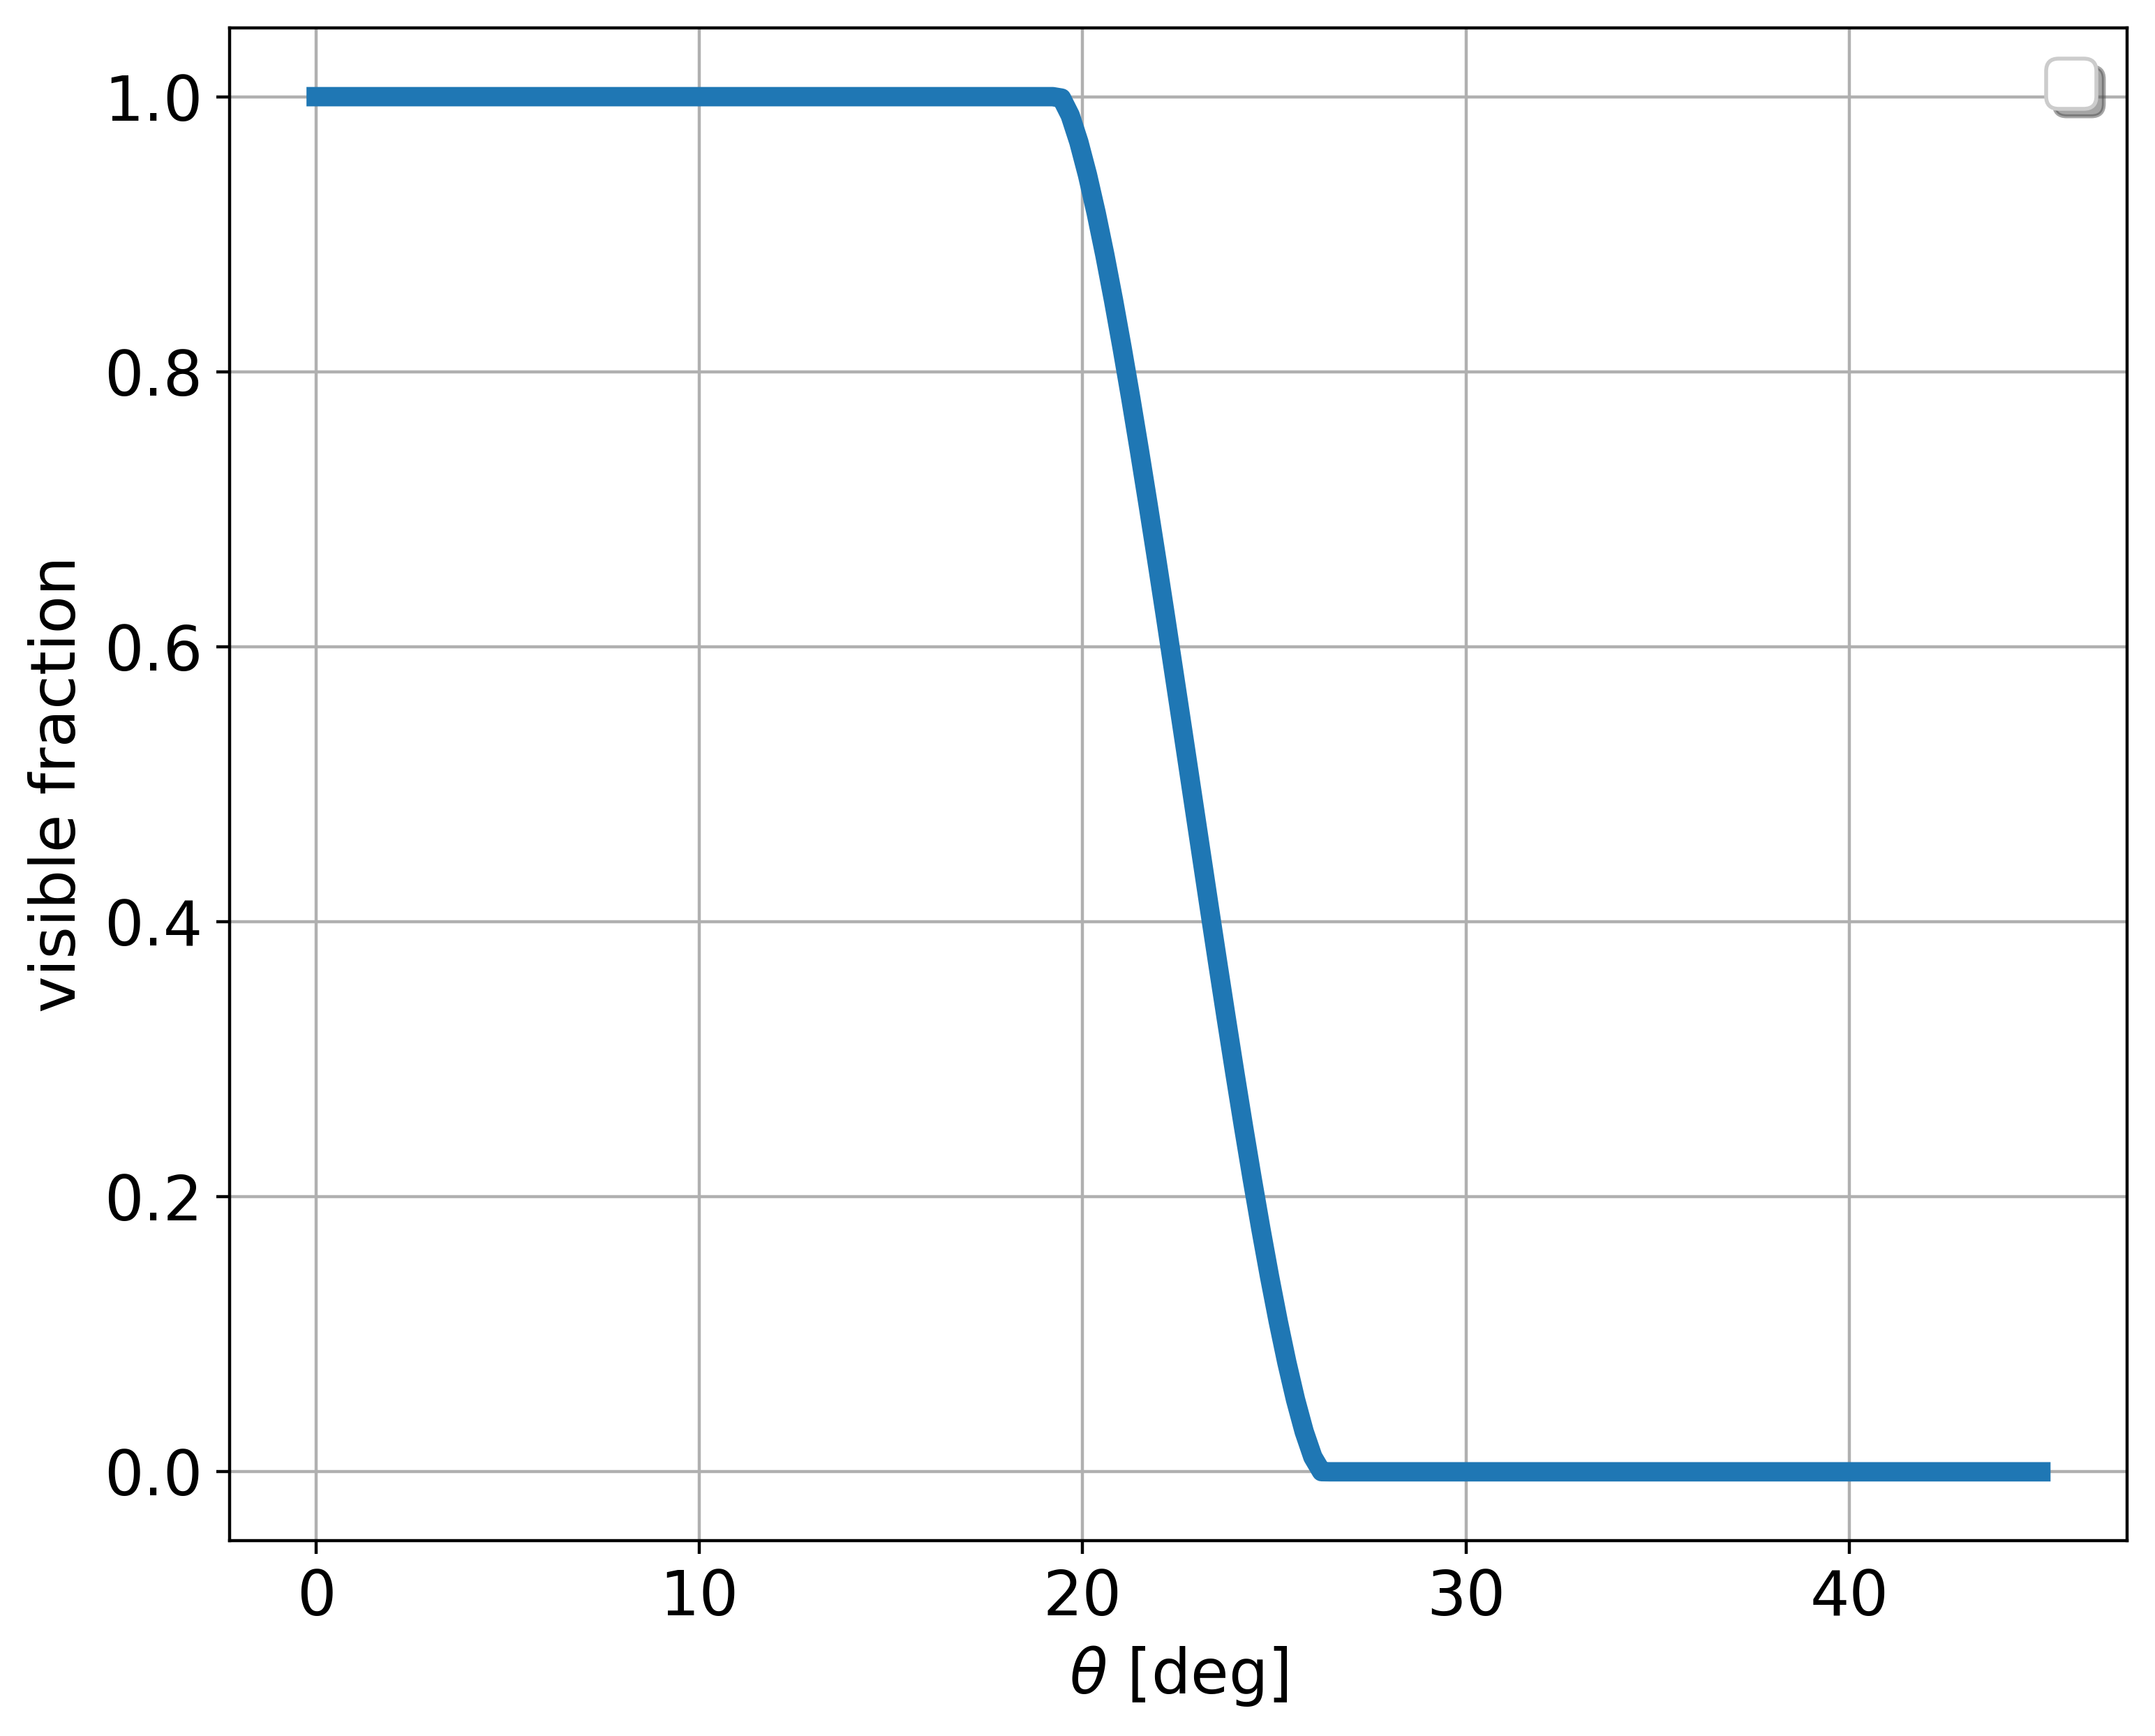

In [17]:

xs = np.linspace(0,35, 200)
# ys = visible_fraction(xs * degree)
ys = [visible_fraction(x * degree) for x in xs]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()
ax1.plot(xs,ys,
        # color = "k" ,label = r"calib weights",
         lw= 5)


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"visible fraction")

plt.legend(shadow=True)
plt.tight_layout()
plt.grid(True)

### Plot extracted beam shape with l_eff and visible fraction

In [18]:
degree = np.pi/180
# remember to input values in radians
def beta(theta, l_eff):

    output = np.zeros_like(theta) 
    cond = np.abs(l_eff * np.tan(theta)) < 1
    output[cond] =  np.arccos(l_eff * np.tan(theta[cond]))
    return output


def U(theta, l_eff):
    # Move conditional to beta only
    return (2*beta(theta, l_eff)-np.sin(2*beta(theta, l_eff)))/np.pi

def V(theta, l_eff):
    # Move conditional to beta only
    return np.sin(beta(theta, l_eff))**3

def jd(theta, l_eff):
    return np.cos(theta) * U(theta, l_eff)

def jw(theta, l_eff):
    result = (
    (4/(3*np.pi))*(1-1/(2*l_eff + 1)) * (1/l_eff) 
    * (np.cos(theta)**2 / np.sin(theta)) 
    * (1-V(theta, l_eff))
    + (1/(2*l_eff + 1))*np.cos(theta) * (1-U(theta, l_eff))
    )
    return result

def j(theta, l_eff):
    return jd(theta, l_eff) + jw(theta, l_eff)

In [19]:
def new_H_profile(theta, l_eff):
    return j(theta, l_eff) * visible_fraction(theta)

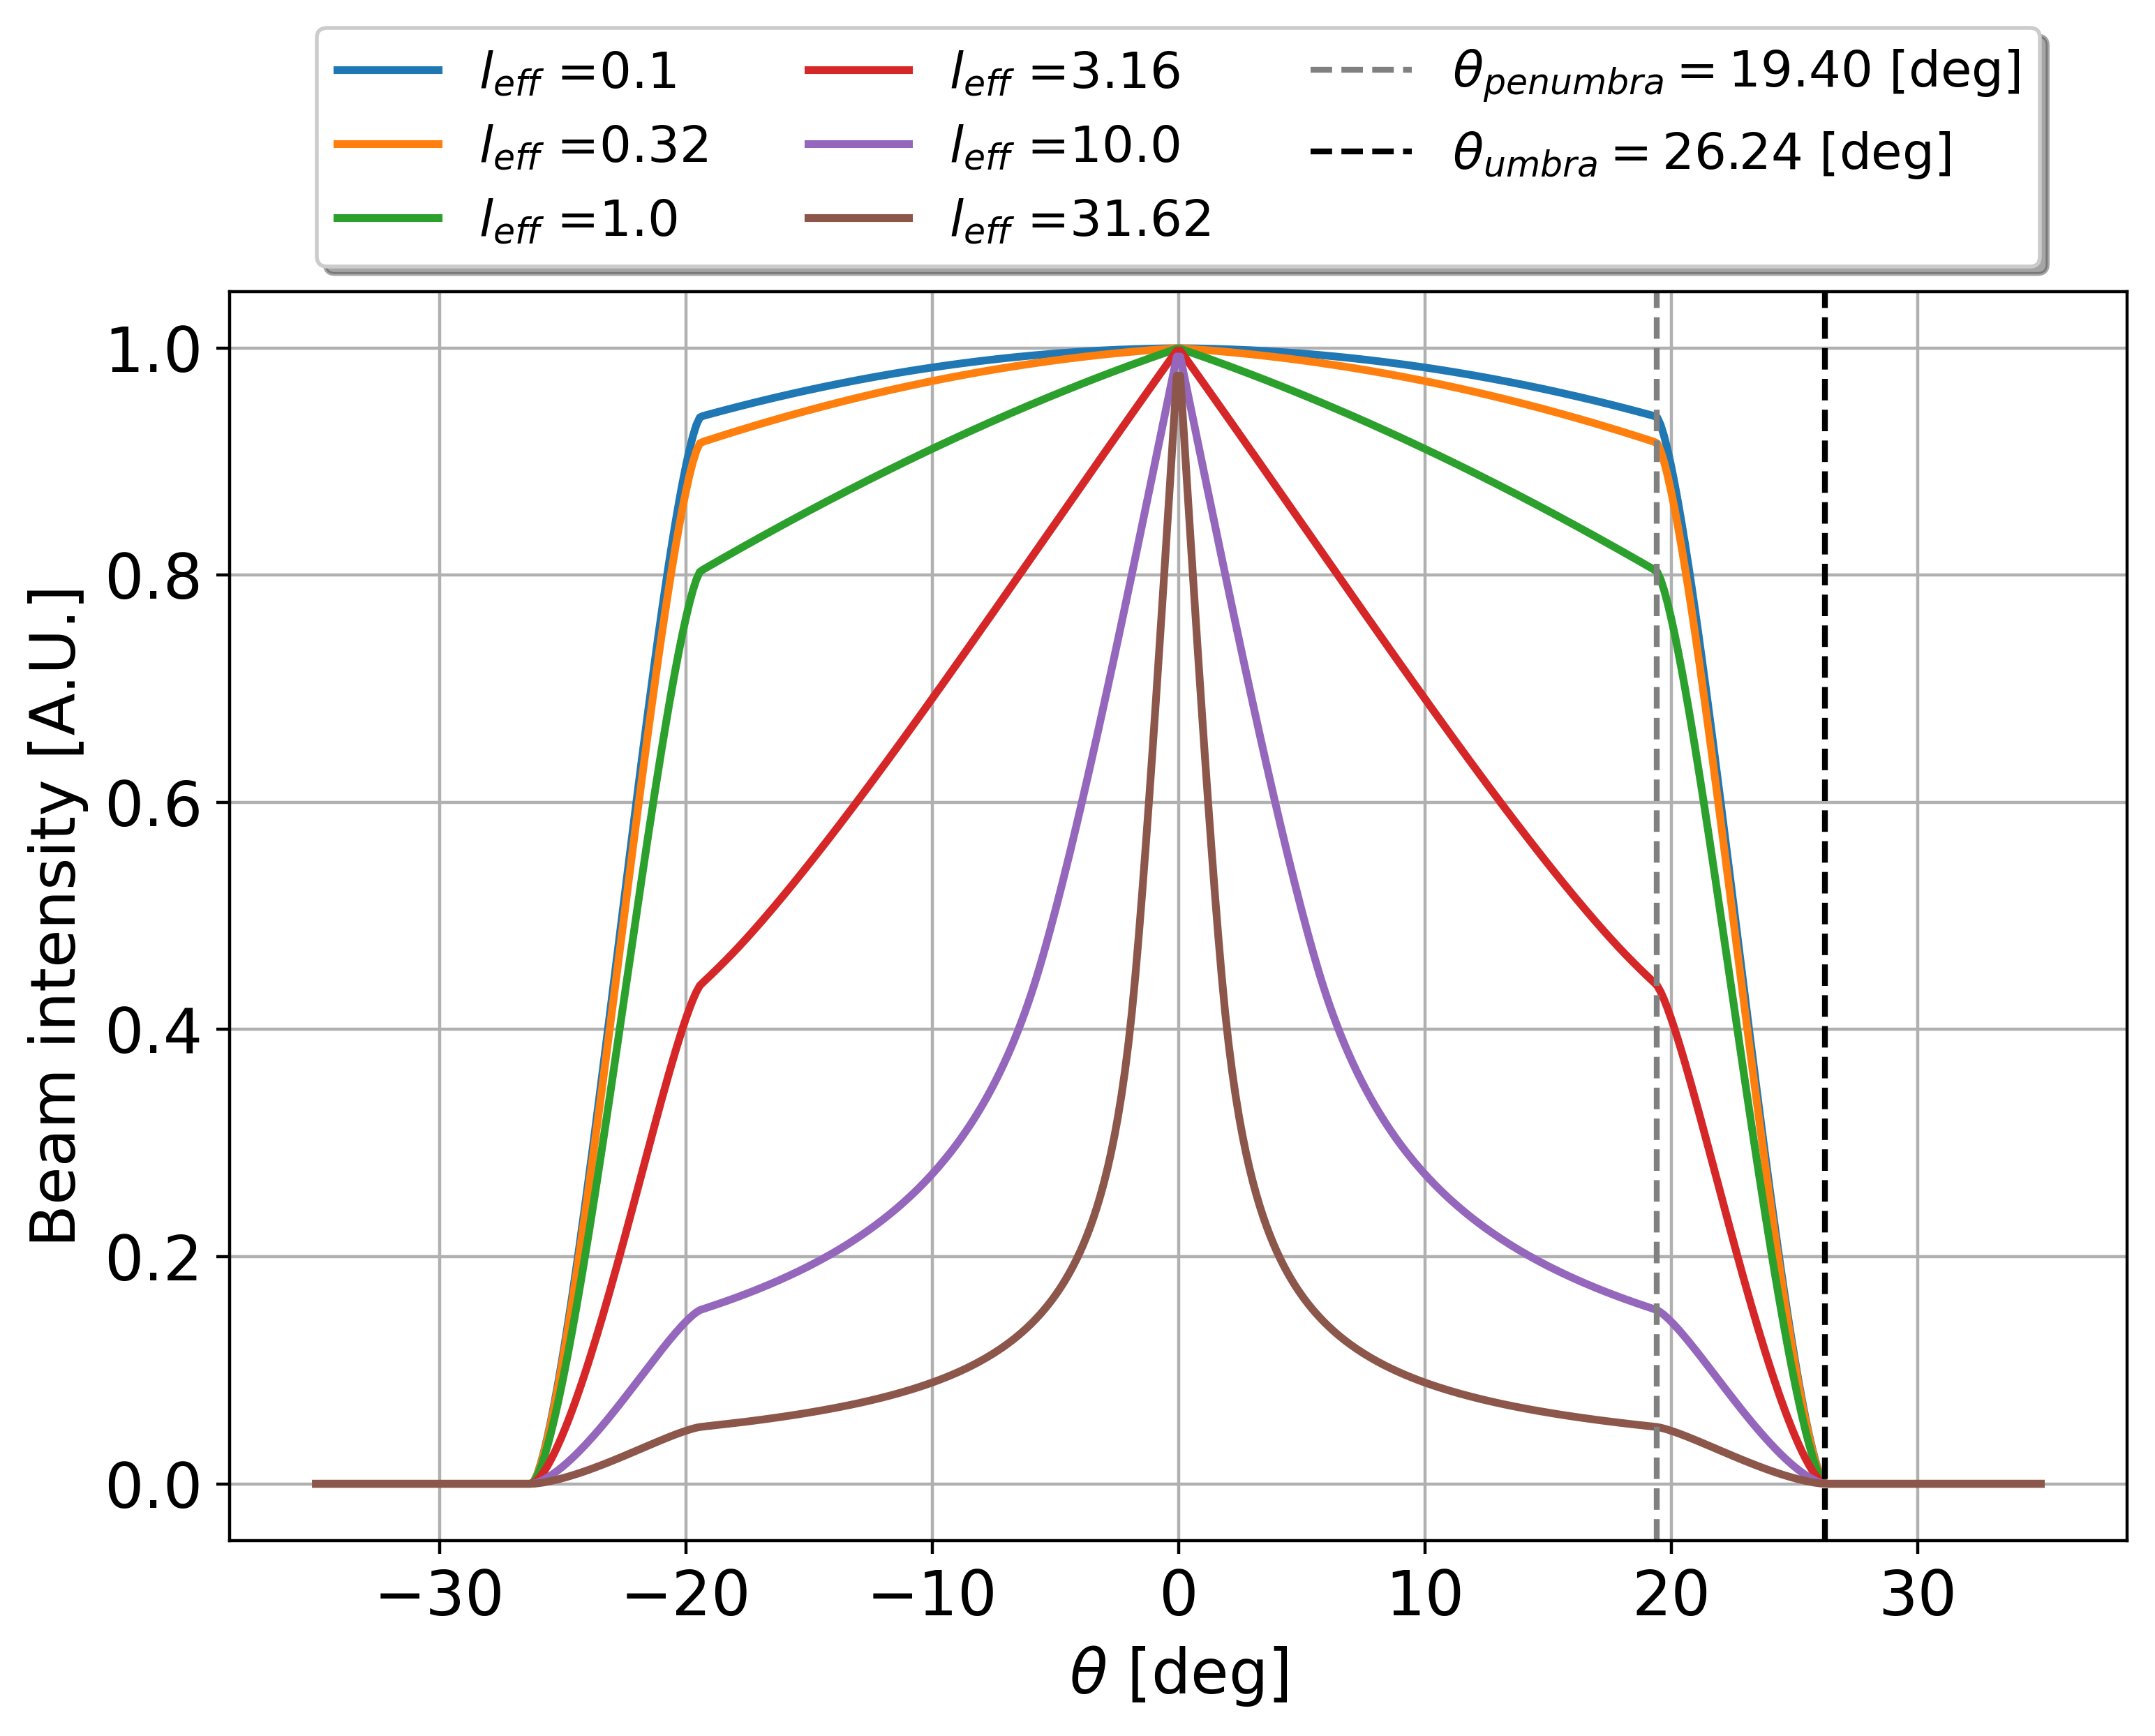

In [28]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [new_H_profile(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

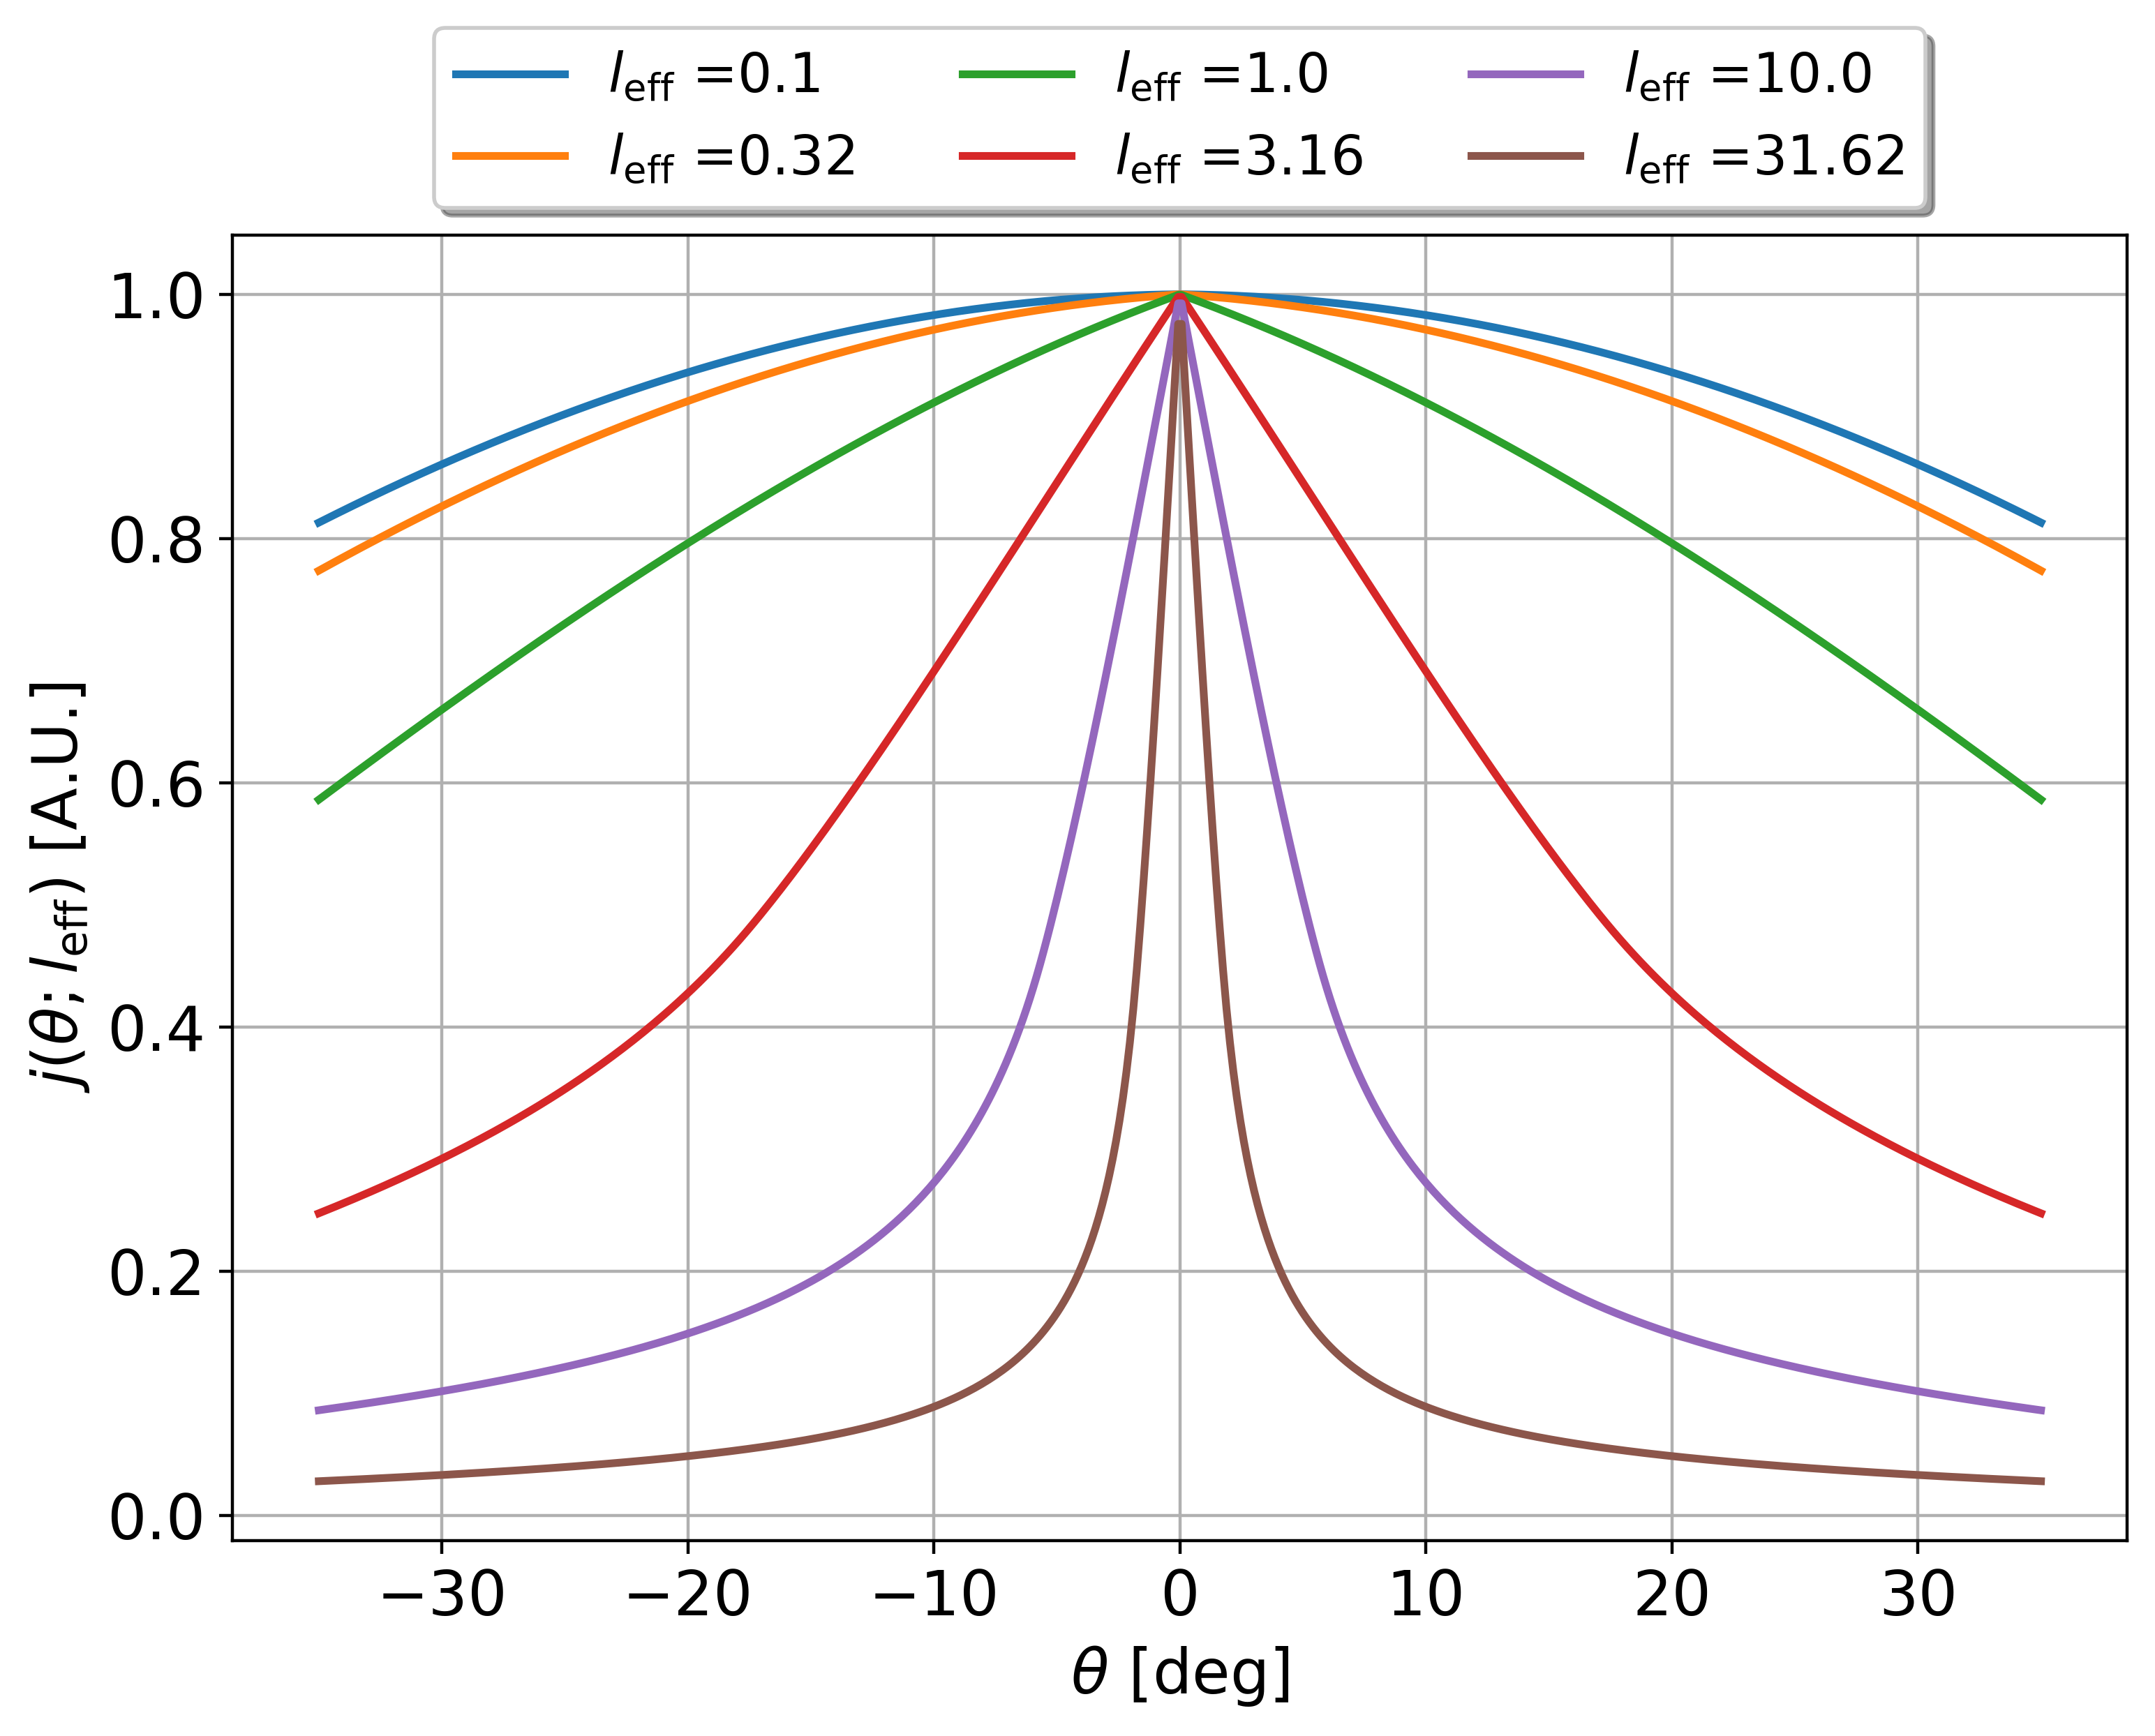

In [34]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [j(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)